# Semantic Interactions Simulation Evaluation

## Imports and Reading Data

In [1]:
import sys
import os
cwd = os.getcwd()
print(cwd)
nwd = os.path.join(cwd, "..", "narratives")
sys.path.insert(0, nwd)

C:\narrative-maps\tests


In [2]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import itertools  
from math import log, exp, sqrt
import matplotlib.pyplot as plt
from ast import literal_eval
import json

# LP
from packages.solve_LP import solve_LP, compute_sim
from packages.graph_utils import *
from packages.globals import *

In [3]:
base_total_samples = 10

## Reading Data

In [4]:
def clean_publication(graph_df):
    publication_dict = {'www.bbc.com': 'bbc',
                    'www.aljazeera.com': 'ajz',
                    'www.nytimes.com': 'nyt',
                    'www.theguardian.com': 'tgn',
                    'edition.cnn.com': 'cnn',
                    'www.cnn.com': 'cnn',
                    'Reuters': 'reu',
                    'www.reuters.com': 'reu',
                    'Business Insider': 'bin',
                    'CNN': 'cnn',
                    'The Hill': 'hill',
                    'The New York Times': 'nyt',
                    'CNBC': 'cnbc',
                    'Breitbart': 'brb',
                    'www.breitbart.com': 'brb',
                    'Fox News': 'fox',
                    'www.foxnews.com': 'fox',
                    'CIA': 'cia',
                    'FBI': 'fbi',
                    'Army CID': 'cid',
                    'INS': 'ins',
                    'Sanctioned Intercepts': 'sai',
                    'NSA': 'nsa',
                    'abcnews.go.com': 'abc',
                    'apnews.com': 'apn',
                    'www.firstpost.com': 'fpost',
                    'theconversation.com': 'tcon',
                    'nypost.com': 'nyp',
                    'newscomworld.com': 'nwc',
                    'havanatimes.org': 'hvt',
                    'www.nbcnews.com': 'nbc',
                    'www.local10.com': 'l10',
                    'www.trtworld.com': 'trt',
                    'www.washingtonpost.com': 'wapo',
                    'www.xinhuanet.com': 'xinhua'
                    }
    graph_df['publication'] = graph_df['publication'].map(publication_dict).fillna('default')
    return graph_df

In [5]:
def read_query(dataset, start_date=None, end_date=None, partial=False):
    data_file = str(dataset) + '.csv'
    data_file_path = os.path.join(cwd, "..", "data", data_file)
    if partial:
        columns_to_skip = 'embed'
        query = pd.read_csv(data_file_path, usecols=lambda x: x not in columns_to_skip)
    else:
        query = pd.read_csv(data_file_path)
    query = clean_publication(query)

    # Inferring datatime format (this might bring issues depending on the data!)
    query['date'] = pd.to_datetime(query['date'], infer_datetime_format=True) #8/22/2019 12:15

    if start_date is not None:
        query = query[(query['date'] >= pd.to_datetime(start_date, format='%Y-%m-%d'))]

    if end_date is not None:
        query = query[(query['date'] <= pd.to_datetime(end_date, format='%Y-%m-%d'))]

    if not partial:
        embed_list = ['embed']
        query[embed_list] = query[embed_list].replace(r'( )+', ',', regex=True)
        query[embed_list] = query[embed_list].replace('\[,', '[', regex=True)
        query[embed_list] = query[embed_list].replace(',]', ']', regex=True)
        query[embed_list] = query[embed_list].applymap(literal_eval).applymap(np.array)

        if 'cluster_vec' in query.columns: # Predefined clusters!
            query[['cluster_vec']] = query[['cluster_vec']].applymap(literal_eval).applymap(np.array)

    query.reset_index(inplace=True)
    query['id'] = [str(i) for i in list(query.index)]

    return query

In [6]:
dataset = "cuba_160"
query = read_query(dataset)
sim_table = compute_sim(query)

In [7]:
aux = query[(query.title.str.contains(r'(?:\s|\b)[Uu](?:\.)?[sS](?:\.)?[Aa]?(?:\.)?(?:\s|\b)', regex=True) |
                                 query.title.str.contains('united states', case=False)) & 
                                 ~(query.title.str.contains('miami', case=False) 
                                   | query.title.str.contains('florida', case=False))]
print(len(aux.index))

30


## Map Generation

In [8]:
def generate_map(query, dataset, previous_actions=[], k_input=8, mincover_input=20, window=30, start_nodes=[], 
                 verbose=True, random_state=42, force_cluster=False, use_temporal=True, use_entities=False):
    operation_list = []
    for item in previous_actions:
        if item.get("action") == "add-node":
            for node in item['content']:
                operation_list.append("AN:" + node)
        elif item.get("action") == "add-edge":
             operation_list.append("AE:" + item["content"])
        elif item.get("action") == "remove-node":
            for node in item['content']:
                operation_list.append("RN:" + node)
        elif item.get("action") == "remove-edge":
            for edge in item['content']:
                operation_list.append("RE:" + edge)
        elif item.get("action") == "add-cluster-list":
             operation_list.append("ACL:" + str(item['content'][0]) + "-" + str(item['content'][1]))
    
    # Solve LP and create new graph_df.
    cluster_size_est = np.sqrt(len(query.index))/2
    cluster_size_est = 5 * round(cluster_size_est / 5) # Round to nearest multiple of 5
    n_neighbors = 2
    if len(query.index) > 40:
        n_neighbors = 10
    elif len(query.index) > 120:
        n_neighbors = cluster_size_est

    graph_df_new, status, scatter_df, sim_table, clust_sim_table, ent_table, ent_doc_list, cluster_assignment = solve_LP(query, 
        dataset=dataset, operations=operation_list, 
        K=k_input, mincover=mincover_input/100, 
        min_samples=2, min_cluster_size=cluster_size_est, n_neighbors=n_neighbors, min_dist=1/100,
        start_nodes=start_nodes, verbose=verbose, random_state=random_state, force_cluster=force_cluster,
        use_temporal=use_temporal, use_entities=use_entities)
    status_msg = "LP Status: " + status[1] + ", Clusters: " + str(status[0])

    if 'Optimal' in status[1]:
        # Generate graph from LP solution.
        G = build_graph(graph_df_new)
        storylines = graph_stories(G, start_nodes=start_nodes, end_nodes=[])
        status_msg += ", Storylines: " + str(len(storylines))

        # We now apply transitive reduction.
        remove_list_transitive = []
        for story in storylines:
            max_idx = len(story) - 1
            for idx, node in enumerate(story):
                out_edges = G.out_edges(node)
                # If it's not the last element in the story (no need to clean the last one, because there are no in-story outgoing edges)
                if idx != max_idx:
                    for edge in out_edges:
                        if edge[1] in story and edge[1] != story[idx + 1]: # If it's an in-story edge and not the immediately adjacent one.
                            remove_list_transitive.append(edge)
        G.remove_edges_from(remove_list_transitive)
        # We now filter redundant interstory connections.
        remove_list_interstory = []
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            keep_set = set()
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            if len(edge_boundary_list_i) > 0:
                earliest_i = min(edge_boundary_list_i, key = lambda t: (t[0], t[1]))
                latest_i = max(edge_boundary_list_i, key = lambda t: (t[0], t[1]))
            else:
                earliest_i = None
            if len(edge_boundary_list_j) > 0:
                earliest_j = min(edge_boundary_list_j, key = lambda t: (t[1], t[0]))
                latest_j = max(edge_boundary_list_j, key = lambda t: (t[1], t[0]))
            else:
                earliest_j = None
            if not earliest_i and not earliest_j:
                # No connections
                continue
            elif earliest_i and not earliest_j:
                # One-sided.
                if earliest_i == latest_i: # There's only one connection, keep it.
                    continue
                elif earliest_i[0] == latest_i[0]:
                    # This means that the second values are different, but the first one is the same.
                    # For this special case we keep the earliest one.
                    keep_set.add(earliest_i)
                else:
                    # Keep both
                    keep_set.add(earliest_i)
                    keep_set.add(latest_i)
            elif not earliest_i and earliest_j:
                # One-sided and reversed.
                if earliest_j == latest_j: # There's only one connection, keep it.
                    continue
                elif earliest_j[1] == latest_j[1]:
                    # This means that the first values are different, but the second one is the same.
                    # For this special case we keep the earliest one.
                    keep_set.add(earliest_j)
                else:
                    # Keep both
                    keep_set.add(earliest_j)
                    keep_set.add(latest_j)
            else:
                # Two-sided.
                if earliest_i[0] < earliest_j[1]:
                    # E_i happened first. Keep it
                    keep_set.add(earliest_i)
                    if latest_i[0] > latest_j[1]:
                        # L_i happened last. Keep it.
                        keep_set.add(latest_i)
                    else:
                        keep_set.add(latest_j)
                else:
                    # E_j happened first.
                    keep_set.add(earliest_j)
                    if latest_i[0] > latest_j[1]:
                        # E_i happened last. Keep it.
                        keep_set.add(latest_i)
                    else:
                        keep_set.add(latest_j)
            redundant_edge_set = set(edge_boundary_list_i) | set(edge_boundary_list_j)
            remove_list_interstory += list(redundant_edge_set - keep_set)

        G.remove_edges_from(remove_list_interstory)

        for node in G.nodes:
            sum_node = sum([exp(-data['weight']) for u, v, data in G.out_edges(node, data=True)])
            if sum_node == 0:
                continue
            for u, v, data in G.out_edges(node, data=True):
                G[u][v]['weight'] = -log(exp(-data['weight']) / sum_node)
            sum_node = sum([exp(-G[u][v]['weight']) for u, v, data in G.out_edges(node, data=True)])
        # Update graph_df
        for i, row in graph_df_new.iterrows():
            new_adj_list = [v for u, v in G.out_edges(str(row['id']))]
            new_adj_weights = [exp(-G[u][v]['weight']) for u, v in G.out_edges(str(row['id']))]
            graph_df_new.at[i,'adj_list'] = new_adj_list
            graph_df_new.at[i,'adj_weights'] = new_adj_weights

        for node in G.nodes:  
            sum_node = sum([exp(-data['weight']) for u, v, data in G.out_edges(node, data=True)])
            if sum_node == 0:
                continue
            for u, v, data in G.out_edges(node, data=True):
                G[u][v]['weight'] = -log(exp(-data['weight']) / sum_node)
            sum_node = sum([exp(-data['weight']) for u, v, data in G.out_edges(node, data=True)])

        # Update graph_df
        for i, row in graph_df_new.iterrows():
            new_adj_list = [v for u, v in G.out_edges(str(row['id']))]
            new_adj_weights = [exp(-G[u][v]['weight']) for u, v in G.out_edges(str(row['id']))]
            graph_df_new.at[i,'adj_list'] = new_adj_list
            graph_df_new.at[i,'adj_weights'] = new_adj_weights
            
        #print(graph_df_new)
        return G, graph_df_new, storylines

## Plots

In [9]:
def plot_complexity_metric(all_iterations, all_complexities, column):
    max_val_list = []
    for idx, complexity in enumerate(all_complexities):
        max_val_list.append(max(complexity[column]))
    max_val = max(max_val_list) 
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    ax[0].title.set_text('All runs')
    ax[0].set_xlabel('# of Iterations')
    ax[0].set_ylabel(column)
    ax[0].set_ylim(0, max_val)
    ax[1].title.set_text('Average')
    ax[1].set_xlabel('# of Iterations')
    ax[1].set_ylabel(column)
    ax[1].set_ylim(0, max_val)
    # All elements    
    for idx, complexity in enumerate(all_complexities):
        ax[0].plot(list(range(len(complexity[column]))), complexity[column], '-r')
    # Average
    max_iter = max(all_iterations)
    extended_metric_list = []
    for idx, complexity in enumerate(all_complexities):
        metric_list_extended = list(complexity[column]) + [list(complexity[column])[-1] for _ in range(max_iter - len(complexity[column]))]
        extended_metric_list.append(metric_list_extended)
    extended_metric_array = np.array(extended_metric_list)
    average_metric = np.nanmedian(extended_metric_array, axis=0)
    ax[1].plot(list(range(max_iter)), average_metric, '-r')
    
def plot_error_rate(all_iterations, all_percents):
    max_val_list = []
    for idx, percent_list in enumerate(all_percents):
        max_val_list.append(max(percent_list))
    max_val = max(max_val_list) 
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    ax[0].title.set_text('All runs')
    ax[0].set_xlabel('# of Iterations')
    ax[0].set_ylabel('Error Rate')
    ax[0].set_ylim(0, max_val)
    ax[1].title.set_text('Average')
    ax[1].set_xlabel('# of Iterations')
    ax[1].set_ylabel('Error Rate')
    ax[1].set_ylim(0, max_val)
    # All elements
    for idx, percent_list in enumerate(all_percents):
        ax[0].plot(list(range(all_iterations[idx])), percent_list, '-r')
    # Average
    max_iter = max(all_iterations)
    extended_percent_list = []
    for percent_list in all_percents:
        percent_list_extended = percent_list + [percent_list[-1] for _ in range(max_iter - len(percent_list))]
        extended_percent_list.append(percent_list_extended)
    extended_percent_array = np.array(extended_percent_list)
    average_percent = np.nanmedian(extended_percent_array, axis=0)
    ax[1].plot(list(range(max_iter)), average_percent, '-r')

In [10]:
def plot_all(all_iterations, all_percents, all_complexities):
    plot_error_rate(all_iterations, all_percents)
    plot_complexity_metric(all_iterations, all_complexities, column='Nodes')
    plot_complexity_metric(all_iterations, all_complexities, column='Edges')
    plot_complexity_metric(all_iterations, all_complexities, column='Stories')
    plot_complexity_metric(all_iterations, all_complexities, column='Interstory Connections')

## Operation Templates

In [11]:
add_node = {"action": "add-node", "content": ["node_id"]} # String list of node ids
add_edge = {"action": "add-edge", "content": "edge_id"} # String of edge id
rem_node = {"action": "remove-node", "content": ["node_id"]} # String list of node ids
rem_edge = {"action": "remove-edge", "content": ["edge_id"]} # String list of edge id
cluster_list = {"action": "add-node", "content": "[node_id]-cid"} # String with the format [cluster_node_ids]-cluster_id.

## Remove Nodes
### Removing Nodes from Map (Right-leaning articles only)
Goal: Remove right-biased news articles from the map. We fix a center starting point from Reuters: "Cuba sees biggest protests for decades as pandemic adds to woes" (Node ID: 124)

In [12]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
total_samples = base_total_samples
for i in range(total_samples):
    print("===================================")
    print("Sample #" + str(i))
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter_nodes = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    while percent_filter_nodes > 0:
        G, graph_df, storylines = generate_map(query, dataset, start_nodes=[10], previous_actions=previous_actions, verbose=False, random_state=random_state)
        filter_nodes = graph_df[graph_df.bias == 'Right']
        percent_filter_nodes = len(filter_nodes.index) / len(graph_df.index)
        remove_node_list = [str(node) for node in filter_nodes.id.tolist()]
        remove_node = {"action": "remove-node", "content": remove_node_list}
        previous_actions.append(remove_node)
        percent_list.append(percent_filter_nodes)
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter_nodes, remove_node)
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list

    actions = []
    for action in previous_actions:
        actions += action['content']
    all_iterations.append(inner_iter_count)
    all_percents.append(percent_list)
    all_counts.append(len(actions))
    all_complexities.append(complexity)

Sample #0
Step: 1 0.36363636363636365 {'action': 'remove-node', 'content': ['36', '58', '64', '129', '132', '133', '134', '136']}
Complexity: [22, 27, 12, 3, 9, 17]
Step: 2 0.2608695652173913 {'action': 'remove-node', 'content': ['22', '40', '49', '52', '127', '150']}
Complexity: [23, 28, 9, 3, 6, 14]
Step: 3 0.11538461538461539 {'action': 'remove-node', 'content': ['17', '35', '51']}
Complexity: [26, 29, 8, 5, 3, 11]
Step: 4 0.15384615384615385 {'action': 'remove-node', 'content': ['28', '31', '54', '72']}
Complexity: [26, 29, 7, 4, 3, 10]
Step: 5 0.09090909090909091 {'action': 'remove-node', 'content': ['53', '69']}
Complexity: [22, 26, 8, 3, 5, 12]
Step: 6 0.0 {'action': 'remove-node', 'content': []}
Complexity: [22, 27, 8, 4, 4, 13]
Sample #1
Step: 1 0.3793103448275862 {'action': 'remove-node', 'content': ['35', '40', '47', '53', '64', '66', '71', '73', '108', '116', '127']}
Complexity: [29, 36, 11, 7, 4, 18]
Step: 2 0.3181818181818182 {'action': 'remove-node', 'content': ['16', '2

In [13]:
results_delete_right = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_delete_right_old.json', 'w') as fp:
    json.dump(results_delete_right, fp)

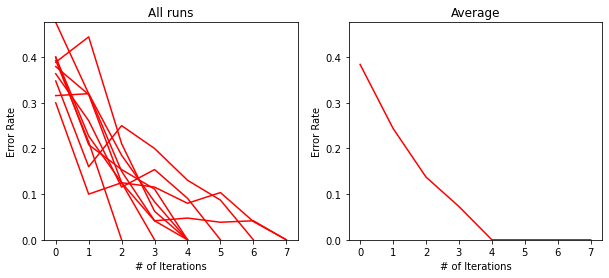

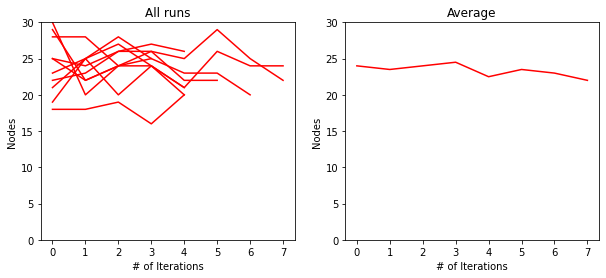

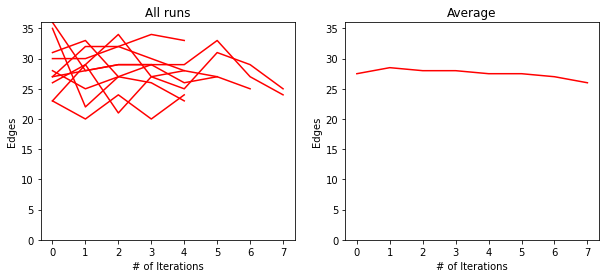

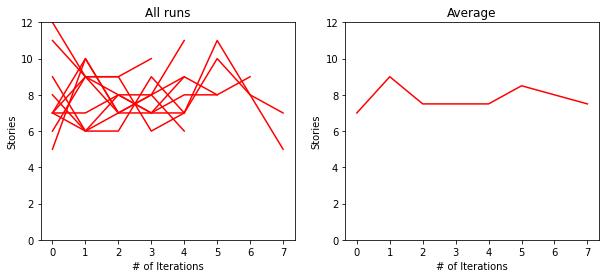

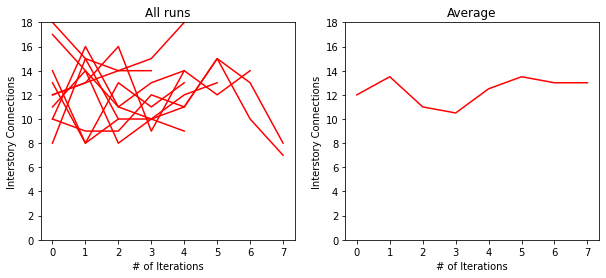

In [14]:
plot_all(all_iterations, all_percents, all_complexities)

### Fox and Breitbart only

In [15]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
total_samples = base_total_samples
for i in range(total_samples):
    print("===================================")
    print("Sample #" + str(i))
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter_nodes = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    while percent_filter_nodes > 0:
        G, graph_df, storylines = generate_map(query, dataset, start_nodes=[10], previous_actions=previous_actions, verbose=False, random_state=random_state)
        filter_nodes = graph_df[graph_df['url'].str.contains('foxnews') | graph_df['url'].str.contains('breitbart')]
        percent_filter_nodes = len(filter_nodes.index) / len(graph_df.index)
        remove_node_list = [str(node) for node in filter_nodes.id.tolist()]
        remove_node = {"action": "remove-node", "content": remove_node_list}
        previous_actions.append(remove_node)
        percent_list.append(percent_filter_nodes)
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter_nodes, remove_node)
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
    actions = []
    for action in previous_actions:
        actions += action['content']
    all_iterations.append(inner_iter_count)
    all_percents.append(percent_list)
    all_counts.append(len(actions))
    all_complexities.append(complexity)

Sample #0
Step: 1 0.2727272727272727 {'action': 'remove-node', 'content': ['36', '58', '64', '129', '132', '136']}
Complexity: [22, 27, 12, 3, 9, 17]
Step: 2 0.25 {'action': 'remove-node', 'content': ['40', '49', '51', '52', '127']}
Complexity: [20, 23, 7, 3, 4, 10]
Step: 3 0.07692307692307693 {'action': 'remove-node', 'content': ['35', '150']}
Complexity: [26, 32, 9, 5, 4, 15]
Step: 4 0.041666666666666664 {'action': 'remove-node', 'content': ['112']}
Complexity: [24, 29, 10, 3, 7, 15]
Step: 5 0.045454545454545456 {'action': 'remove-node', 'content': ['54']}
Complexity: [22, 26, 7, 4, 3, 11]
Step: 6 0.0 {'action': 'remove-node', 'content': []}
Complexity: [20, 23, 7, 3, 4, 10]
Sample #1
Step: 1 0.3103448275862069 {'action': 'remove-node', 'content': ['35', '40', '47', '64', '66', '71', '108', '116', '127']}
Complexity: [29, 36, 11, 7, 4, 18]
Step: 2 0.15384615384615385 {'action': 'remove-node', 'content': ['28', '44', '54', '56']}
Complexity: [26, 31, 11, 5, 6, 16]
Step: 3 0.0769230769

In [16]:
results_delete_right = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_delete_fox_bb_old.json', 'w') as fp:
    json.dump(results_delete_right, fp)

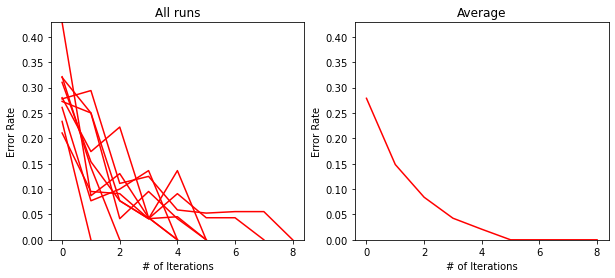

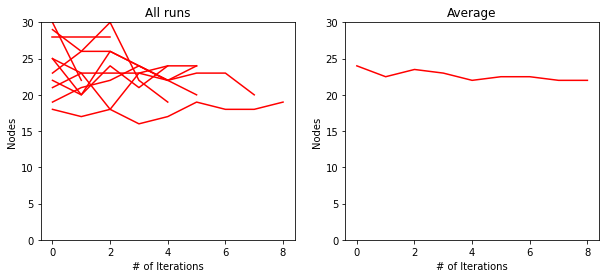

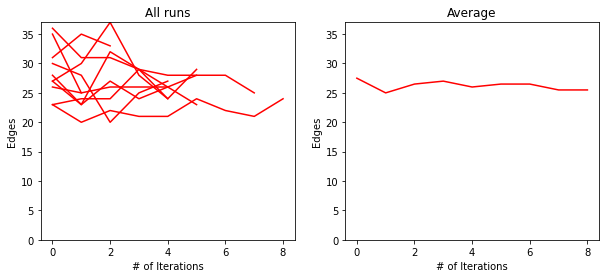

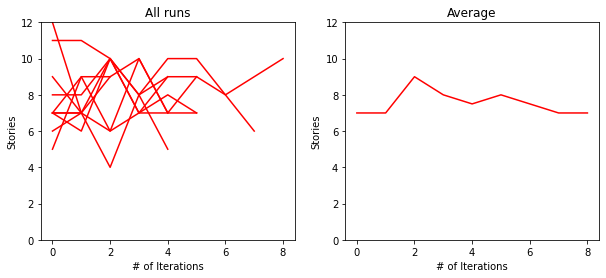

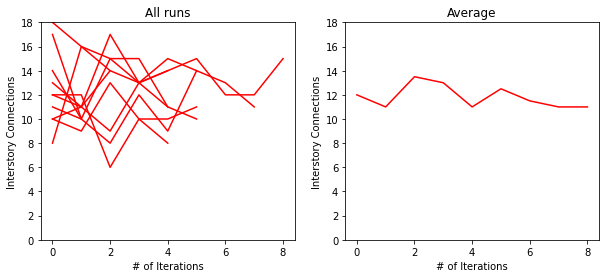

In [17]:
plot_all(all_iterations, all_percents, all_complexities)

### Removing Miami + Florida references
There's 39 after the protests start.

In [18]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
i = 0
total_samples = base_total_samples
while i < total_samples:
    drop = False
    print("===================================")
    print("Sample #" + str(i))
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter_nodes = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    while percent_filter_nodes > 0:
        G, graph_df, storylines = generate_map(query, dataset, start_nodes=[10], previous_actions=previous_actions, 
                                               verbose=False, random_state=random_state, force_cluster=False)
        filter_nodes = graph_df[graph_df.title.str.contains('miami', case=False) | 
                                   graph_df.title.str.contains('florida', case=False)]
        percent_filter_nodes = len(filter_nodes.index) / len(graph_df.index)
        remove_node_list = [str(node) for node in filter_nodes.id.tolist()]
        remove_node = {"action": "remove-node", "content": remove_node_list}
        previous_actions.append(remove_node)
        percent_list.append(percent_filter_nodes)
        if percent_filter_nodes == 0 and inner_iter_count == 0: # first iteration has no miami/florida nodes. 
            drop = True
            total_samples += 1
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter_nodes, remove_node)
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
    actions = []
    i += 1
    for action in previous_actions:
        actions += action['content']
    if not drop:
        all_iterations.append(inner_iter_count)
        all_percents.append(percent_list)
        all_counts.append(len(actions))
        all_complexities.append(complexity)

Sample #0
Step: 1 0.09090909090909091 {'action': 'remove-node', 'content': ['36', '58']}
Complexity: [22, 27, 12, 3, 9, 17]
Step: 2 0.19047619047619047 {'action': 'remove-node', 'content': ['40', '49', '51', '140']}
Complexity: [21, 25, 9, 4, 5, 13]
Step: 3 0.08695652173913043 {'action': 'remove-node', 'content': ['35', '38']}
Complexity: [23, 28, 10, 2, 8, 15]
Step: 4 0.13636363636363635 {'action': 'remove-node', 'content': ['41', '63', '88']}
Complexity: [22, 27, 10, 5, 5, 15]
Step: 5 0.05263157894736842 {'action': 'remove-node', 'content': ['46']}
Complexity: [19, 25, 8, 4, 4, 14]
Step: 6 0.08333333333333333 {'action': 'remove-node', 'content': ['87', '126']}
Complexity: [24, 28, 9, 4, 5, 13]
Step: 7 0.0 {'action': 'remove-node', 'content': []}
Complexity: [21, 27, 10, 4, 6, 16]
Sample #1
Step: 1 0.13793103448275862 {'action': 'remove-node', 'content': ['35', '40', '46', '53']}
Complexity: [29, 36, 11, 7, 4, 18]
Step: 2 0.0 {'action': 'remove-node', 'content': []}
Complexity: [23, 2

In [19]:
results_delete_florida = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_delete_florida_old.json', 'w') as fp:
    json.dump(results_delete_florida, fp)

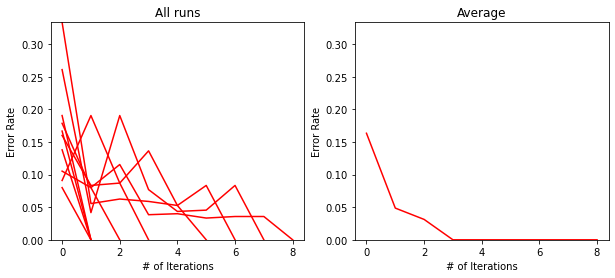

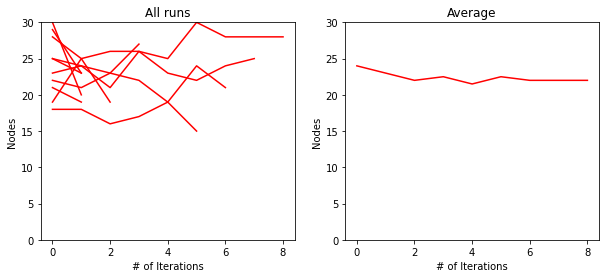

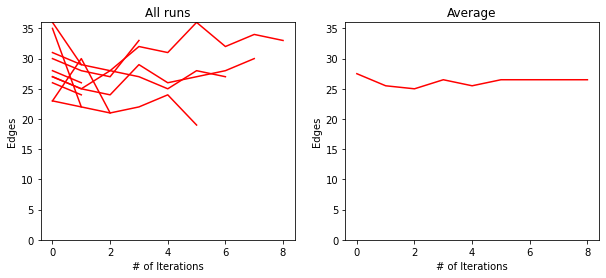

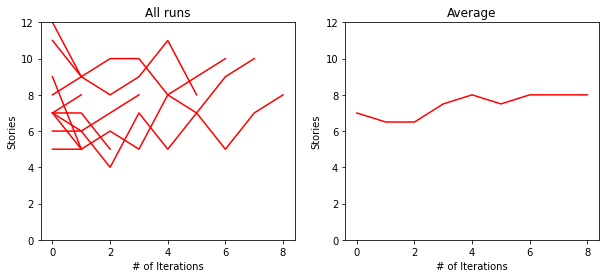

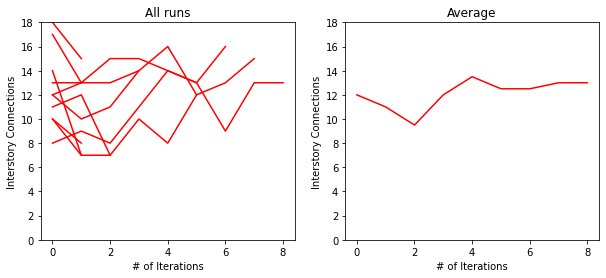

In [20]:
plot_all(all_iterations, all_percents, all_complexities)

## Remove Edges
### Remove Inconsistent Edges
Goal: Remove right-biased news articles from the map. We use the same starting point from before.

In [21]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
total_samples = base_total_samples
for i in range(total_samples):
    print("===================================")
    print("Sample #" + str(i))
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter_edges = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    while percent_filter_edges > 0:
        G, graph_df, storylines = generate_map(query, dataset, start_nodes=[10], previous_actions=previous_actions, verbose=False, random_state=random_state)
        edges = list(G.edges())
        filter_edges = []
        for node_i, node_j in edges:
            bias_i = graph_df.loc[graph_df['id'] == int(node_i)].iloc[0]['bias']
            bias_j = graph_df.loc[graph_df['id'] == int(node_j)].iloc[0]['bias']
            if (bias_i == 'Right' and bias_j == 'Left') or (bias_i == 'Left' and bias_j == 'Right'):
                filter_edges.append((node_i, node_j))
        remove_edge_list = [node_i + "-" + node_j for node_i, node_j in filter_edges]
        percent_filter_edges = len(filter_edges) / len(edges)
        
        remove_edge = {"action": "remove-edge", "content": remove_edge_list}
        previous_actions.append(remove_edge)
        percent_list.append(percent_filter_edges)
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter_edges, remove_edge)
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
    actions = []
    for action in previous_actions:
        actions += action['content']
    all_iterations.append(inner_iter_count)
    all_percents.append(percent_list)
    all_counts.append(len(actions))
    all_complexities.append(complexity)

Sample #0
Step: 1 0.2222222222222222 {'action': 'remove-edge', 'content': ['36-65', '12-36', '13-36', '64-77', '77-129', '124-132']}
Complexity: [22, 27, 12, 3, 9, 17]
Step: 2 0.2 {'action': 'remove-edge', 'content': ['58-90', '64-107', '52-77', '77-112', '90-132', '86-127', '127-138']}
Complexity: [28, 35, 12, 3, 9, 19]
Step: 3 0.16129032258064516 {'action': 'remove-edge', 'content': ['36-50', '50-56', '49-77', '132-138', '86-132']}
Complexity: [25, 31, 10, 6, 4, 16]
Step: 4 0.14814814814814814 {'action': 'remove-edge', 'content': ['36-91', '91-132', '76-77', '77-132']}
Complexity: [24, 27, 9, 4, 5, 12]
Step: 5 0.14285714285714285 {'action': 'remove-edge', 'content': ['36-43', '58-128', '43-56', '128-132']}
Complexity: [24, 28, 10, 3, 7, 14]
Step: 6 0.07142857142857142 {'action': 'remove-edge', 'content': ['36-48', '48-132']}
Complexity: [23, 28, 10, 4, 6, 15]
Step: 7 0.03571428571428571 {'action': 'remove-edge', 'content': ['48-58']}
Complexity: [24, 28, 9, 5, 4, 13]
Step: 8 0.0 {'ac

Step: 14 0.037037037037037035 {'action': 'remove-edge', 'content': ['45-61']}
Complexity: [22, 27, 8, 5, 3, 13]
Step: 15 0.037037037037037035 {'action': 'remove-edge', 'content': ['16-33']}
Complexity: [23, 27, 6, 4, 2, 10]
Step: 16 0.1 {'action': 'remove-edge', 'content': ['13-18', '18-27', '43-71']}
Complexity: [27, 30, 6, 5, 1, 9]
Step: 17 0.04 {'action': 'remove-edge', 'content': ['76-113']}
Complexity: [22, 25, 5, 2, 3, 8]
Step: 18 0.0 {'action': 'remove-edge', 'content': []}
Complexity: [25, 28, 7, 4, 3, 10]
Sample #7
Step: 1 0.16129032258064516 {'action': 'remove-edge', 'content': ['33-59', '33-73', '36-48', '127-138', '90-127']}
Complexity: [28, 31, 5, 5, 0, 8]
Step: 2 0.16129032258064516 {'action': 'remove-edge', 'content': ['33-36', '33-84', '34-36', '59-86', '90-132']}
Complexity: [27, 31, 9, 8, 1, 13]
Step: 3 0.07142857142857142 {'action': 'remove-edge', 'content': ['33-35', '61-84']}
Complexity: [23, 28, 6, 4, 2, 11]
Step: 4 0.08571428571428572 {'action': 'remove-edge', 'c

In [22]:
results_delete_edges = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_delete_edges_old.json', 'w') as fp:
    json.dump(results_delete_edges, fp)

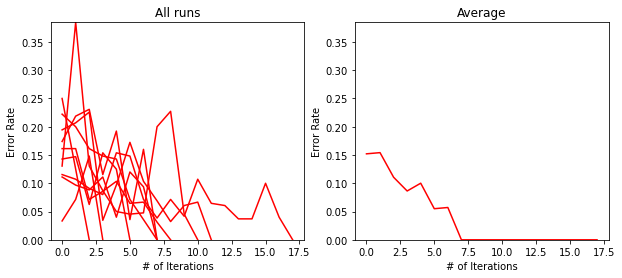

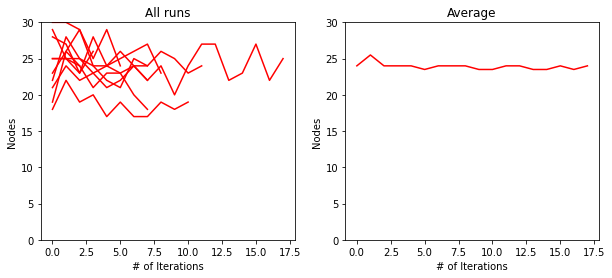

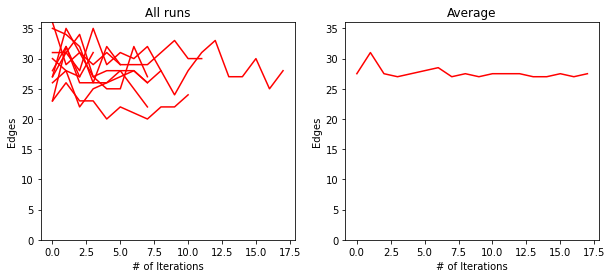

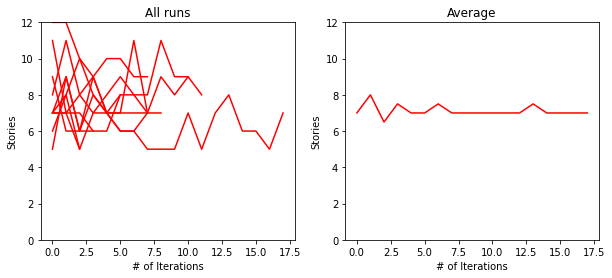

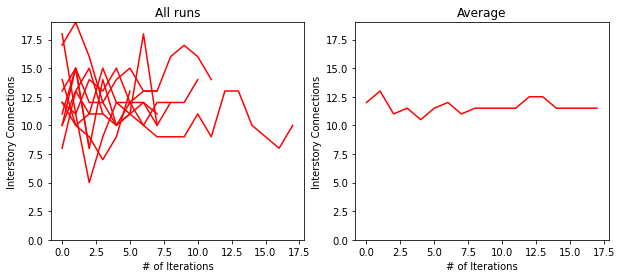

In [23]:
plot_all(all_iterations, all_percents, all_complexities)

## Add Edges + Remove Edges
### Make Storylines Consistent (Starting from "Center" Storyline)

In [24]:
from collections import Counter
def most_common(lst):
    # Exclude local and center.
    lst[:] = [x for x in lst if x != 'Center' and x != 'Local']
    if len(lst) == 0:
        return None
    data = Counter(lst)
    return max(lst, key=data.get)

In [25]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
total_samples = base_total_samples

for i in range(total_samples):
    print("===================================")
    print("Sample #" + str(i))
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter_nodes = 1.0
    percent_list_nodes = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    while percent_filter_nodes > 0:
        G, graph_df, storylines = generate_map(query, dataset, start_nodes=[10], previous_actions=previous_actions, verbose=False, random_state=random_state)
        nodes = list(G.nodes())
        remove_node_list = []
        add_edges = []
        #print("Storylines: " + str(storylines))
        for story in storylines:
            #print("Current story: " + str(story))
            story_biases = [graph_df.loc[graph_df['id'] == int(story_node)].iloc[0]['bias'] for story_node in story]
            story_bias = most_common(story_biases)
            opposite_bias = None
            if story_bias == 'Left':
                opposite_bias = 'Right'
            else:
                opposite_bias = 'Left'
            skip_count = 0
            mark = None
            if opposite_bias is not None:
                for node in story:
                    bias = graph_df.loc[graph_df['id'] == int(node)].iloc[0]['bias']
                    if mark is not None and skip_count > 0 and bias != opposite_bias:
                        add_edge = {"action": "add-edge", "content": str(mark) + "-" + str(node)} # String of edge id
                        add_edges.append(str(mark) + "-" + str(node))
                        previous_actions.append(add_edge)
                        mark = node
                        skip_count = 0
                    if bias != opposite_bias:
                        mark = node
                    else:
                        remove_node_list.append(node)
                        skip_count += 1            
        remove_node = {"action": "remove-node", "content": remove_node_list}
        for node in remove_node_list:
            previous_actions[:] = [action for action in previous_actions if not (action['action'] == 'add-edge' and str(node) in action['content'].split("-"))]
        previous_actions.append(remove_node)                
        percent_filter_nodes = len(remove_node_list) / len(nodes)              
        percent_list_nodes.append(percent_filter_nodes)
        
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter_nodes, remove_node, "add-edge: " + str(add_edges))
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
    actions = []
    for action in previous_actions:
        if type(action['content']) == list:
            actions += action['content']
        else:
            actions.append(action['content'])
    all_iterations.append(inner_iter_count)
    all_percents.append(percent_list_nodes)
    all_counts.append(len(actions))
    all_complexities.append(complexity)

Sample #0
Step: 1 0.09090909090909091 {'action': 'remove-node', 'content': ['12', '77']} add-edge: ['36-64', '64-129']
Complexity: [22, 27, 12, 3, 9, 17]
Step: 2 0.0625 {'action': 'remove-node', 'content': ['103', '34']} add-edge: []
Complexity: [32, 31, 14, 9, 5, 13]
Step: 3 0.10810810810810811 {'action': 'remove-node', 'content': ['141', '40', '124', '39']} add-edge: ['27-55', '129-133', '35-70']
Complexity: [37, 35, 13, 11, 2, 11]
Step: 4 0.06060606060606061 {'action': 'remove-node', 'content': ['138', '51']} add-edge: ['15-157']
Complexity: [33, 32, 13, 10, 3, 12]
Step: 5 0.046511627906976744 {'action': 'remove-node', 'content': ['28', '91']} add-edge: ['27-30']
Complexity: [43, 44, 20, 12, 8, 21]
Step: 6 0.08333333333333333 {'action': 'remove-node', 'content': ['72', '146', '87', '67']} add-edge: ['27-101', '45-88']
Complexity: [48, 52, 26, 10, 16, 30]
Step: 7 0.05128205128205128 {'action': 'remove-node', 'content': ['83', '127']} add-edge: []
Complexity: [39, 38, 19, 10, 9, 18]
S

Step: 3 0.0 {'action': 'remove-node', 'content': []} add-edge: []
Complexity: [22, 20, 9, 6, 3, 7]
Sample #7
Step: 1 0.10714285714285714 {'action': 'remove-node', 'content': ['33', '48', '127']} add-edge: ['10-73', '36-63', '90-138']
Complexity: [28, 31, 5, 5, 0, 8]
Step: 2 0.10714285714285714 {'action': 'remove-node', 'content': ['65', '86', '67']} add-edge: ['19-122', '59-85']
Complexity: [28, 33, 7, 6, 1, 12]
Step: 3 0.12903225806451613 {'action': 'remove-node', 'content': ['59', '73', '128', '34']} add-edge: ['27-98']
Complexity: [31, 26, 14, 10, 4, 9]
Step: 4 0.0967741935483871 {'action': 'remove-node', 'content': ['101', '121', '18']} add-edge: ['100-131', '15-25']
Complexity: [31, 26, 10, 8, 2, 5]
Step: 5 0.08823529411764706 {'action': 'remove-node', 'content': ['117', '135', '146']} add-edge: []
Complexity: [34, 25, 13, 11, 2, 4]
Step: 6 0.05 {'action': 'remove-node', 'content': ['104']} add-edge: []
Complexity: [20, 15, 9, 7, 2, 4]
Step: 7 0.07407407407407407 {'action': 'remov

In [26]:
results_consistent_story = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_consistent_story_old.json', 'w') as fp:
    json.dump(results_consistent_story, fp)

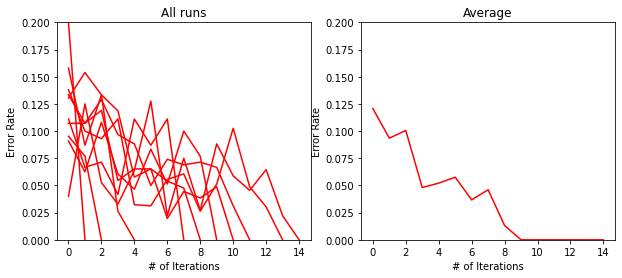

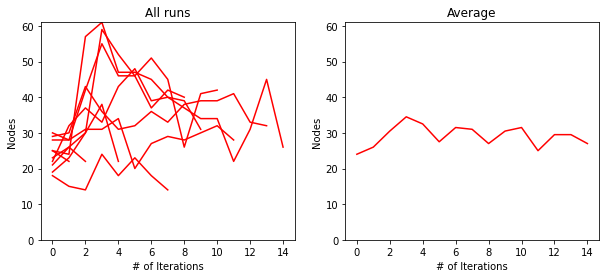

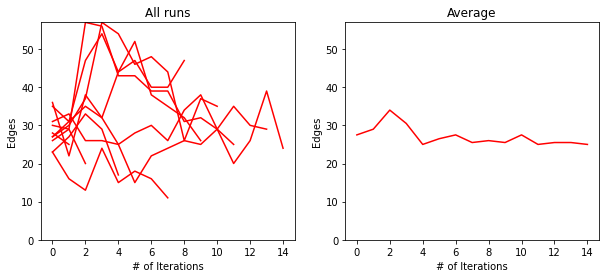

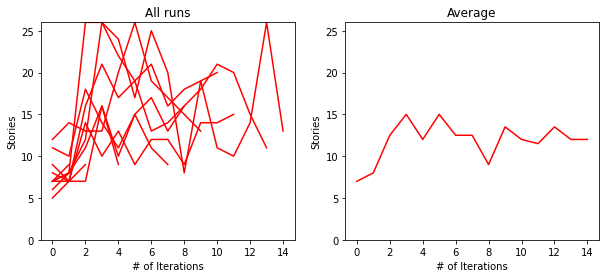

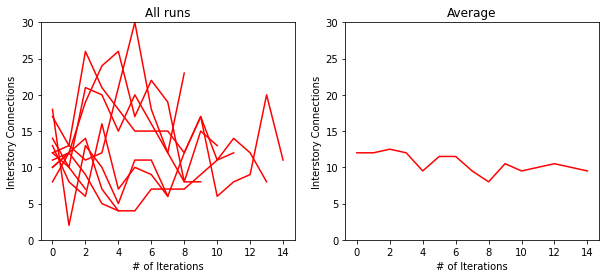

In [27]:
plot_all(all_iterations, all_percents, all_complexities)

## "Clustering"
2 clusters only: High-bias Breitbart vs Center-unbiased storylines.
Metric: internal storyline consistency (avoid connections between high-bias and low-bias articles)

### Semi-supervised umap with constraints

In [28]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
i = 0
total_samples = base_total_samples
while i < total_samples:
    print("===================================")
    print("Sample #" + str(i) + " (Valid Sample #" + str(len(all_complexities)) + ")")
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consistent throughout the same iteration.
    drop = False
    while percent_filter > 0:
        G, graph_df, storylines = generate_map(query, dataset, k_input=8, start_nodes=[10], previous_actions=previous_actions, 
                                               verbose=False, random_state=random_state, force_cluster=True)
        nodes = list(G.edges())
        
        breitbart_nodes = graph_df[graph_df.url.str.contains('breitbart')] # Cluster 1
        center_nodes = graph_df[graph_df.bias == 'Center'] # Cluster 2
        breitbart_cluster_full = [str(node) for node in breitbart_nodes['id'].tolist()]
        center_cluster_full = [str(node) for node in center_nodes['id'].tolist()]
        
        previous_breitbart = [node for node_list in previous_actions for node in node_list["content"][0] if node_list["content"][1] == 1]
        previous_center = [node for node_list in previous_actions for node in node_list["content"][0] if node_list["content"][1] == 2]

        print("Previous actions:")
        print(previous_breitbart)
        print(previous_center)
        
        breitbart_cluster_int = sorted([int(node) for node in list(set(breitbart_cluster_full).difference(previous_breitbart))])
        center_cluster_int = sorted([int(node) for node in list(set(center_cluster_full).difference(previous_center))])
        
        breitbart_cluster = [str(node) for node in breitbart_cluster_int]
        center_cluster = [str(node) for node in center_cluster_int]
        
        breitbart_action = {"action": "add-cluster-list", "content": [breitbart_cluster[:min(3, len(breitbart_cluster))], 1]}
        center_action = {"action": "add-cluster-list", "content": [center_cluster[:min(3, len(center_cluster))], 2]}
        
        previous_actions.append(breitbart_action)
        previous_actions.append(center_action)
        
        non_isolated_nodes = set()
        breitbart_n = len(breitbart_cluster_full)
        center_n = len(center_cluster_full)

        count_same_story = 0
        count_direct_connection = 0
        count_same_parent = 0
        count_same_children = 0
        for combination in itertools.combinations(breitbart_cluster_full,2):
            pred_i = G.predecessors(combination[0])
            pred_j = G.predecessors(combination[1])
            succ_i = G.successors(combination[0])
            succ_j = G.successors(combination[1])
            if any(all(node in story for node in combination) for story in storylines) : # pair is in the same storyline
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_story += 1
            elif G.has_edge(*combination) or G.has_edge(*reversed(combination)): # pair is directly connected (even if not in the same storyline)
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_direct_connection += 1
            elif set(pred_i) & set(pred_j): # pair shares the same parent/predecessors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_parent += 1
            elif set(succ_i) & set(succ_j): # pair shares the same children/succesors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_children += 1
                
        for combination in itertools.combinations(center_cluster_full,2):
            pred_i = G.predecessors(combination[0])
            pred_j = G.predecessors(combination[1])
            succ_i = G.successors(combination[0])
            succ_j = G.successors(combination[1])
            try:
                sp_1 = nx.shortest_path_length(G, combination[0], combination[1])
            except nx.NetworkXNoPath:
                sp_1 = 0
            try:
                sp_2 = nx.shortest_path_length(G, combination[1], combination[0])
            except nx.NetworkXNoPath:
                sp_2 = 0
            has_path = (sp_1 == 2) or (sp_2 == 2) # Separation of 2. 
            if any(all(node in story for node in combination) for story in storylines) : # pair is in the same storyline
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_story += 1
            elif G.has_edge(*combination) or G.has_edge(*reversed(combination)): # pair is directly connected (even if not in the same storyline)
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_direct_connection += 1
            elif set(pred_i) & set(pred_j): # pair shares the same parent/predecessors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_parent += 1
            elif set(succ_i) & set(succ_j): # pair shares the same children/succesors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_children += 1

                
        print("Total cluster 1: " + str(breitbart_n))
        print("Total cluster 2: " + str(center_n))
        print("Same story " + str(count_same_story), 
              "Direct connection " + str(count_direct_connection), 
              "Same parent " + str(count_same_parent),
              "Same children " + str(count_same_children))
        if breitbart_n + center_n == 0:
            percent_filter = 0.0
        else:        
            percent_filter = 1 - len(non_isolated_nodes) / (breitbart_n + center_n)
        percent_list.append(percent_filter)
        
        if percent_filter == 0 and inner_iter_count == 0: 
            # if the map was perfect from the start, we will need more samples and we should drop this one.
            drop = True
            total_samples += 1
        
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter, breitbart_action, center_action)
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
        
    i += 1
    actions = []
    for action in previous_actions:
        if action['action'] == 'add-cluster-list':
            actions += action['content'][0] 
        elif type(action['content']) == list:
            actions += action['content']
        else:
            actions.append(action['content'])
            
    if not drop:
        all_iterations.append(inner_iter_count)
        all_percents.append(percent_list)
        all_counts.append(len(actions))
        all_complexities.append(complexity)

Sample #0 (Valid Sample #0)
Previous actions:
[]
[]
Total cluster 1: 3
Total cluster 2: 8
Same story 2 Direct connection 0 Same parent 4 Same children 1
Step: 1 0.2727272727272727 {'action': 'add-cluster-list', 'content': [['36', '58', '136'], 1]} {'action': 'add-cluster-list', 'content': [['10', '85', '109'], 2]}
Complexity: [22, 27, 12, 3, 9, 17]
Previous actions:
['36', '58', '136']
['10', '85', '109']
Total cluster 1: 9
Total cluster 2: 19
Same story 14 Direct connection 5 Same parent 1 Same children 5
Step: 2 0.2142857142857143 {'action': 'add-cluster-list', 'content': [['23', '44', '45'], 1]} {'action': 'add-cluster-list', 'content': [['24', '25', '37'], 2]}
Complexity: [56, 64, 19, 14, 5, 27]
Previous actions:
['36', '58', '136', '23', '44', '45']
['10', '85', '109', '24', '25', '37']
Total cluster 1: 10
Total cluster 2: 22
Same story 25 Direct connection 5 Same parent 7 Same children 8
Step: 3 0.0625 {'action': 'add-cluster-list', 'content': [['47', '66', '71'], 1]} {'action': 

Previous actions:
['23', '36', '45', '44', '47', '58', '19', '66', '71', '72', '103', '84', '150', '136', '54']
['10', '41', '85', '57', '60', '62', '24', '37', '78', '25', '70', '92', '74', '100', '105', '75', '106', '110', '119', '120', '137', '79', '81', '142']
Total cluster 1: 16
Total cluster 2: 25
Same story 126 Direct connection 9 Same parent 1 Same children 7
Step: 9 0.024390243902439046 {'action': 'add-cluster-list', 'content': [['28'], 1]} {'action': 'add-cluster-list', 'content': [['153'], 2]}
Complexity: [62, 69, 16, 7, 9, 23]
Previous actions:
['23', '36', '45', '44', '47', '58', '19', '66', '71', '72', '103', '84', '150', '136', '54', '28']
['10', '41', '85', '57', '60', '62', '24', '37', '78', '25', '70', '92', '74', '100', '105', '75', '106', '110', '119', '120', '137', '79', '81', '142', '153']
Total cluster 1: 17
Total cluster 2: 31
Same story 47 Direct connection 13 Same parent 2 Same children 14
Step: 10 0.04166666666666663 {'action': 'add-cluster-list', 'content': 

Previous actions:
[]
[]
Total cluster 1: 6
Total cluster 2: 8
Same story 5 Direct connection 4 Same parent 4 Same children 0
Step: 1 0.0 {'action': 'add-cluster-list', 'content': [['36', '45', '47'], 1]} {'action': 'add-cluster-list', 'content': [['10', '14', '75'], 2]}
Complexity: [21, 26, 7, 4, 3, 12]
Sample #7 (Valid Sample #5)
Previous actions:
[]
[]
Total cluster 1: 3
Total cluster 2: 9
Same story 11 Direct connection 0 Same parent 1 Same children 0
Step: 1 0.33333333333333337 {'action': 'add-cluster-list', 'content': [['36', '66', '84'], 1]} {'action': 'add-cluster-list', 'content': [['10', '41', '60'], 2]}
Complexity: [28, 31, 5, 5, 0, 8]
Previous actions:
['36', '66', '84']
['10', '41', '60']
Total cluster 1: 9
Total cluster 2: 16
Same story 18 Direct connection 7 Same parent 3 Same children 3
Step: 2 0.07999999999999996 {'action': 'add-cluster-list', 'content': [['19', '23', '28'], 1]} {'action': 'add-cluster-list', 'content': [['14', '24', '25'], 2]}
Complexity: [49, 61, 20, 

Previous actions:
['45', '103', '150', '19', '36', '47', '54', '66', '136', '23', '28', '44']
['10', '62', '92', '137', '139', '142', '24', '37', '75', '25', '41', '57']
Total cluster 1: 13
Total cluster 2: 23
Same story 18 Direct connection 12 Same parent 2 Same children 19
Step: 5 0.02777777777777779 {'action': 'add-cluster-list', 'content': [['71'], 1]} {'action': 'add-cluster-list', 'content': [['14', '74', '81'], 2]}
Complexity: [74, 101, 27, 18, 9, 54]
Previous actions:
['45', '103', '150', '19', '36', '47', '54', '66', '136', '23', '28', '44', '71']
['10', '62', '92', '137', '139', '142', '24', '37', '75', '25', '41', '57', '14', '74', '81']
Total cluster 1: 15
Total cluster 2: 28
Same story 47 Direct connection 30 Same parent 15 Same children 24
Step: 6 0.023255813953488413 {'action': 'add-cluster-list', 'content': [['84', '116'], 1]} {'action': 'add-cluster-list', 'content': [['80', '99', '100'], 2]}
Complexity: [81, 128, 24, 17, 7, 71]
Previous actions:
['45', '103', '150', '

Previous actions:
['103', '66', '23', '44', '45', '19', '28', '47', '71', '84', '136']
['10', '78', '81', '24', '25', '57', '37', '62', '70', '41', '74', '75', '60', '92', '99']
Total cluster 1: 13
Total cluster 2: 24
Same story 38 Direct connection 14 Same parent 3 Same children 14
Step: 6 0.027027027027026973 {'action': 'add-cluster-list', 'content': [['54', '116'], 1]} {'action': 'add-cluster-list', 'content': [['85', '110', '120'], 2]}
Complexity: [65, 86, 23, 16, 7, 44]
Previous actions:
['103', '66', '23', '44', '45', '19', '28', '47', '71', '84', '136', '54', '116']
['10', '78', '81', '24', '25', '57', '37', '62', '70', '41', '74', '75', '60', '92', '99', '85', '110', '120']
Total cluster 1: 14
Total cluster 2: 26
Same story 42 Direct connection 15 Same parent 2 Same children 14
Step: 7 0.025000000000000022 {'action': 'add-cluster-list', 'content': [['36'], 1]} {'action': 'add-cluster-list', 'content': [['80', '106', '115'], 2]}
Complexity: [73, 104, 21, 19, 2, 52]
Previous acti

In [29]:
results_clustering = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_clustering_bb_center_old.json', 'w') as fp:
    json.dump(results_clustering, fp)

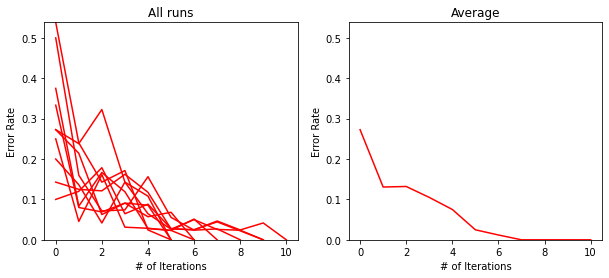

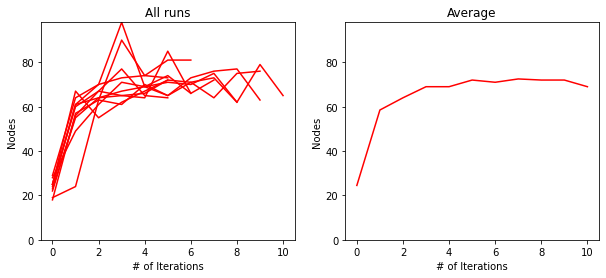

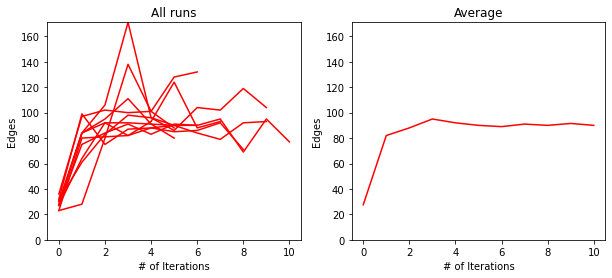

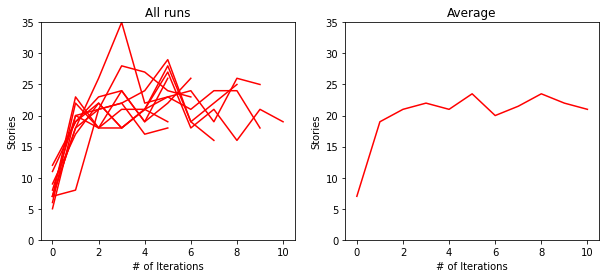

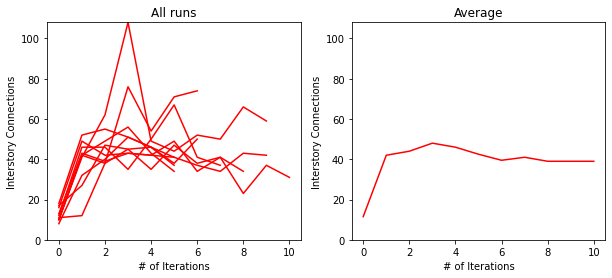

In [30]:
plot_all(all_iterations, all_percents, all_complexities)

### Test with Florida/Miami news vs general US news

In [31]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
i = 0
total_samples = base_total_samples
while i < total_samples:
    print("===================================")
    print("Sample #" + str(i) + " (Valid Sample #" + str(len(all_complexities)) + ")")
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    drop = False
    
    while percent_filter > 0:
        G, graph_df, storylines = generate_map(query, dataset, k_input=8, start_nodes=[10], previous_actions=previous_actions, 
                                               verbose=False, random_state=random_state, force_cluster=True)
        nodes = list(G.edges())
        
        breitbart_nodes = graph_df[graph_df.title.str.contains('miami', case=False) | 
                                   graph_df.title.str.contains('florida', case=False)] # Cluster 1
        center_nodes = graph_df[(graph_df.title.str.contains(r'(?:\s|\b)[Uu](?:\.)?[sS](?:\.)?[Aa]?(?:\.)?(?:\s|\b)', regex=True) |
                                 graph_df.title.str.contains('united states', case=False)) & 
                                 ~(graph_df.title.str.contains('miami', case=False) 
                                   | graph_df.title.str.contains('florida', case=False))] # Cluster 2
        breitbart_cluster = [str(node) for node in breitbart_nodes['id'].tolist()]
        center_cluster = [str(node) for node in center_nodes['id'].tolist()]
        
        breitbart_action = {"action": "add-cluster-list", "content": [breitbart_cluster, 1]}
        center_action = {"action": "add-cluster-list", "content": [center_cluster, 2]}

        breitbart_cluster_full = [str(node) for node in breitbart_nodes['id'].tolist()]
        center_cluster_full = [str(node) for node in center_nodes['id'].tolist()]
        
        previous_breitbart = [node for node_list in previous_actions for node in node_list["content"][0] if node_list["content"][1] == 1]
        previous_center = [node for node_list in previous_actions for node in node_list["content"][0] if node_list["content"][1] == 2]

        print("Previous actions:")
        print(previous_breitbart)
        print(previous_center)
        
        breitbart_cluster_int = sorted([int(node) for node in list(set(breitbart_cluster_full).difference(previous_breitbart))])
        center_cluster_int = sorted([int(node) for node in list(set(center_cluster_full).difference(previous_center))])
        
        breitbart_cluster = [str(node) for node in breitbart_cluster_int]
        center_cluster = [str(node) for node in center_cluster_int]
        
        breitbart_action = {"action": "add-cluster-list", "content": [breitbart_cluster[:min(3, len(breitbart_cluster))], 1]}
        center_action = {"action": "add-cluster-list", "content": [center_cluster[:min(3, len(center_cluster))], 2]}
        
        previous_actions.append(breitbart_action)
        previous_actions.append(center_action)
        
        non_isolated_nodes = set()
        breitbart_n = len(breitbart_cluster_full)
        center_n = len(center_cluster_full)

        count_same_story = 0
        count_direct_connection = 0
        count_same_parent = 0
        count_same_children = 0
        count_has_path = 0
        for combination in itertools.combinations(breitbart_cluster_full,2):
            pred_i = G.predecessors(combination[0])
            pred_j = G.predecessors(combination[1])
            succ_i = G.successors(combination[0])
            succ_j = G.successors(combination[1])
            if any(all(node in story for node in combination) for story in storylines) : # pair is in the same storyline
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_story += 1
            elif G.has_edge(*combination) or G.has_edge(*reversed(combination)): # pair is directly connected (even if not in the same storyline)
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_direct_connection += 1
            elif set(pred_i) & set(pred_j): # pair shares the same parent/predecessors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_parent += 1
            elif set(succ_i) & set(succ_j): # pair shares the same children/succesors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_children += 1
                
        for combination in itertools.combinations(center_cluster_full,2):
            pred_i = G.predecessors(combination[0])
            pred_j = G.predecessors(combination[1])
            succ_i = G.successors(combination[0])
            succ_j = G.successors(combination[1])
            if any(all(node in story for node in combination) for story in storylines) : # pair is in the same storyline
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_story += 1
            elif G.has_edge(*combination) or G.has_edge(*reversed(combination)): # pair is directly connected (even if not in the same storyline)
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_direct_connection += 1
            elif set(pred_i) & set(pred_j): # pair shares the same parent/predecessors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_parent += 1
            elif set(succ_i) & set(succ_j): # pair shares the same children/succesors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_children += 1

        print("Total cluster 1: " + str(breitbart_n))
        print("Total cluster 2: " + str(center_n))
        print("Same story " + str(count_same_story), 
              "Direct connection " + str(count_direct_connection), 
              "Same parent " + str(count_same_parent),
              "Same children " + str(count_same_children))
        
        if breitbart_n + center_n == 0:
            percent_filter = 0.0
        else:
            percent_filter = 1 - len(non_isolated_nodes) / (breitbart_n + center_n)
        
        if percent_filter == 0 and inner_iter_count == 0: 
            # if the map was perfect from the start, we will need more samples and we should drop this one.
            drop = True
            total_samples += 1
            
        percent_list.append(percent_filter)

        
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter, breitbart_action, center_action)
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
    i += 1
    actions = []
    for action in previous_actions:
        if action['action'] == 'add-cluster-list':
            actions += action['content'][0] 
        elif type(action['content']) == list:
            actions += action['content']
        else:
            actions.append(action['content'])
    if not drop:
        all_iterations.append(inner_iter_count)
        all_percents.append(percent_list)
        all_counts.append(len(actions))
        all_complexities.append(complexity)

Sample #0 (Valid Sample #0)
Previous actions:
[]
[]
Total cluster 1: 2
Total cluster 2: 2
Same story 0 Direct connection 0 Same parent 0 Same children 0
Step: 1 1.0 {'action': 'add-cluster-list', 'content': [['36', '58'], 1]} {'action': 'add-cluster-list', 'content': [['65', '139'], 2]}
Complexity: [22, 27, 12, 3, 9, 17]
Previous actions:
['36', '58']
['65', '139']
Total cluster 1: 6
Total cluster 2: 16
Same story 10 Direct connection 0 Same parent 0 Same children 6
Step: 2 0.2727272727272727 {'action': 'add-cluster-list', 'content': [['35', '46', '63'], 1]} {'action': 'add-cluster-list', 'content': [['21', '22', '24'], 2]}
Complexity: [64, 81, 24, 15, 9, 41]
Previous actions:
['36', '58', '35', '46', '63']
['65', '139', '21', '22', '24']
Total cluster 1: 8
Total cluster 2: 6
Same story 3 Direct connection 5 Same parent 2 Same children 1
Step: 3 0.1428571428571429 {'action': 'add-cluster-list', 'content': [['88', '97', '126'], 1]} {'action': 'add-cluster-list', 'content': [['119'], 2]}

Previous actions:
['36', '41', '53', '35', '38', '49', '46', '63', '56', '68', '40', '51', '122']
['139', '146', '21', '22', '25', '105', '116', '119', '54', '65', '110', '24', '29', '33']
Total cluster 1: 16
Total cluster 2: 19
Same story 22 Direct connection 12 Same parent 0 Same children 16
Step: 6 0.1428571428571429 {'action': 'add-cluster-list', 'content': [['94', '126', '140'], 1]} {'action': 'add-cluster-list', 'content': [['111', '112', '121'], 2]}
Complexity: [71, 104, 21, 18, 3, 54]
Previous actions:
['36', '41', '53', '35', '38', '49', '46', '63', '56', '68', '40', '51', '122', '94', '126', '140']
['139', '146', '21', '22', '25', '105', '116', '119', '54', '65', '110', '24', '29', '33', '111', '112', '121']
Total cluster 1: 16
Total cluster 2: 20
Same story 22 Direct connection 14 Same parent 2 Same children 13
Step: 7 0.05555555555555558 {'action': 'add-cluster-list', 'content': [[], 1]} {'action': 'add-cluster-list', 'content': [['74', '75', '156'], 2]}
Complexity: [74, 10

Previous actions:
['36', '63', '46', '53', '56', '35', '38', '49', '51', '68', '87', '58', '88', '122', '40', '94', '97']
['54', '104', '139', '65', '110', '24', '25', '33', '74', '105', '112', '22', '29', '80']
Total cluster 1: 18
Total cluster 2: 19
Same story 31 Direct connection 12 Same parent 2 Same children 19
Step: 7 0.05405405405405406 {'action': 'add-cluster-list', 'content': [['41'], 1]} {'action': 'add-cluster-list', 'content': [['21', '111', '128'], 2]}
Complexity: [71, 98, 19, 16, 3, 46]
Previous actions:
['36', '63', '46', '53', '56', '35', '38', '49', '51', '68', '87', '58', '88', '122', '40', '94', '97', '41']
['54', '104', '139', '65', '110', '24', '25', '33', '74', '105', '112', '22', '29', '80', '21', '111', '128']
Total cluster 1: 18
Total cluster 2: 19
Same story 31 Direct connection 16 Same parent 3 Same children 19
Step: 8 0.05405405405405406 {'action': 'add-cluster-list', 'content': [[], 1]} {'action': 'add-cluster-list', 'content': [['146', '156'], 2]}
Complexi

Previous actions:
['36', '41', '49', '35', '38', '51', '58', '87', '88', '46', '94', '97']
['21', '33', '139', '24', '25', '65', '22', '29', '54']
Total cluster 1: 15
Total cluster 2: 15
Same story 27 Direct connection 10 Same parent 1 Same children 19
Step: 5 0.1333333333333333 {'action': 'add-cluster-list', 'content': [['56', '68', '122'], 1]} {'action': 'add-cluster-list', 'content': [['74', '110', '112'], 2]}
Complexity: [64, 85, 21, 11, 10, 42]
Previous actions:
['36', '41', '49', '35', '38', '51', '58', '87', '88', '46', '94', '97', '56', '68', '122']
['21', '33', '139', '24', '25', '65', '22', '29', '54', '74', '110', '112']
Total cluster 1: 16
Total cluster 2: 16
Same story 26 Direct connection 15 Same parent 5 Same children 23
Step: 6 0.0 {'action': 'add-cluster-list', 'content': [['40'], 1]} {'action': 'add-cluster-list', 'content': [['80', '111', '115'], 2]}
Complexity: [69, 103, 19, 16, 3, 53]
Sample #8 (Valid Sample #8)
Previous actions:
[]
[]
Total cluster 1: 4
Total clus

In [32]:
results_clustering = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_clustering_florida_old.json', 'w') as fp:
    json.dump(results_clustering, fp)

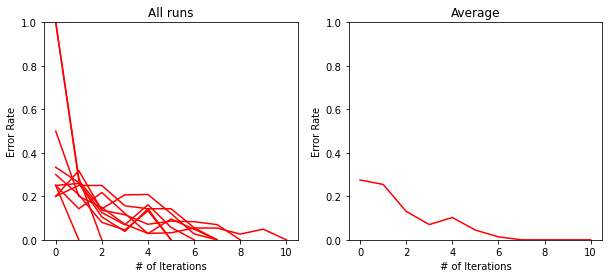

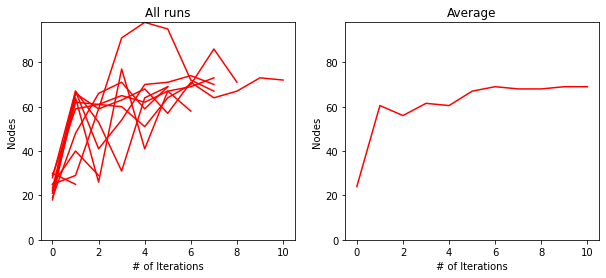

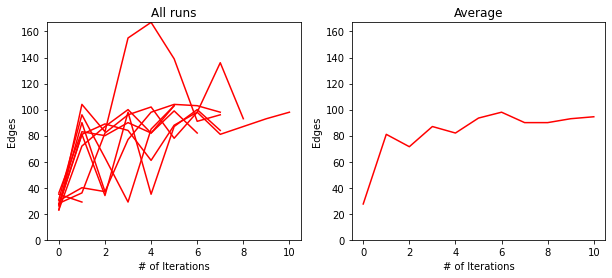

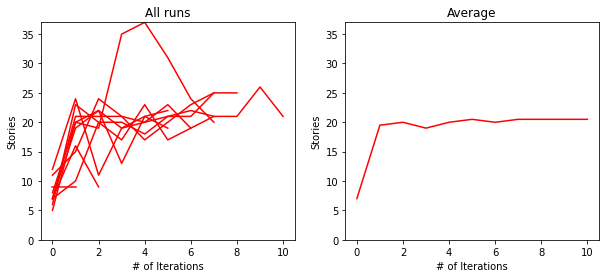

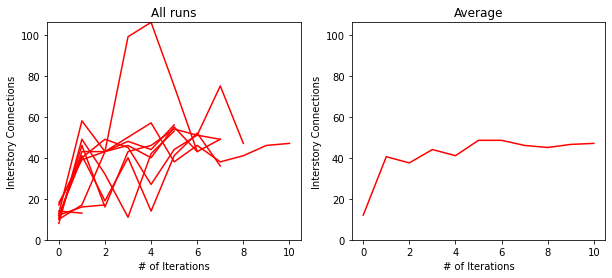

In [33]:
plot_all(all_iterations, all_percents, all_complexities)

## Add Node
Adding nodes and clustering.

### Miami + Florida

In [34]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
total_samples = base_total_samples
subset_query = query.loc[10:].astype({'id': 'int32'})
i = 0

while i < total_samples:
    print("===================================")
    print("Sample #" + str(i) + " (Valid Sample #" + str(len(all_complexities)) + ")")
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter = 1.0
    percent_list = []
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    drop = False
    while percent_filter > 0:
        G, graph_df, storylines = generate_map(query, dataset, k_input=8, start_nodes=[10], 
                                               previous_actions=previous_actions, verbose=False, 
                                               random_state=random_state, force_cluster=True)
        
        all_relevant_nodes = subset_query[subset_query.title.str.contains('miami', case=False) 
                                                 | subset_query.title.str.contains('florida', case=False)]
        relevant_nodes = graph_df[graph_df.title.str.contains('miami', case=False) | 
                                   graph_df.title.str.contains('florida', case=False)]
        
        unselected_relevant_nodes = (all_relevant_nodes.merge(relevant_nodes, on=['id'], how='left', indicator=True)
                                     .query('_merge == "left_only"')
                                     .drop('_merge', 1))
        relevant_node_list = [str(node) for node in relevant_nodes.id.tolist()]
        # Select first 10% nodes.
        percentage = 10
        selected_nodes_df = unselected_relevant_nodes.head(int(len(unselected_relevant_nodes.index) * (percentage / 100)))
        selected_nodes_list = [str(node) for node in selected_nodes_df.id.tolist()]
        
        add_node = {"action": "add-node", "content": selected_nodes_list}
        previous_actions.append(add_node)
        
        # Mark nodes as part of the same cluster
        new_cluster = {"action": "add-cluster-list", "content": [relevant_node_list, 1]}
        previous_actions.append(new_cluster)
        
        # Are the relevant nodes connected?
        non_isolated_nodes = set()
        relevant_node_n = len(relevant_nodes)

        count_same_story = 0
        count_direct_connection = 0
        count_same_parent = 0
        count_same_children = 0
        count_has_path = 0
        for combination in itertools.combinations(relevant_node_list,2):
            pred_i = G.predecessors(combination[0])
            pred_j = G.predecessors(combination[1])
            succ_i = G.successors(combination[0])
            succ_j = G.successors(combination[1])
            if any(all(node in story for node in combination) for story in storylines) : # pair is in the same storyline
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_story += 1
            elif G.has_edge(*combination) or G.has_edge(*reversed(combination)): # pair is directly connected (even if not in the same storyline)
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_direct_connection += 1
            elif set(pred_i) & set(pred_j): # pair shares the same parent/predecessors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_parent += 1
            elif set(succ_i) & set(succ_j): # pair shares the same children/succesors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_children += 1

                
        print("# of Relevant Nodes: " + str(relevant_node_n))
        print("Same story " + str(count_same_story), 
              "Direct connection " + str(count_direct_connection), 
              "Same parent " + str(count_same_parent),
              "Same children " + str(count_same_children))
            
        if relevant_node_n == 0:
            percent_filter = 0.0
        else:
            percent_filter = 1 - len(non_isolated_nodes) / relevant_node_n
        
        if percent_filter == 0 and inner_iter_count == 0: 
            # if the map was perfect from the start, we will need more samples and we should drop this one.
            drop = True
            total_samples += 1
            
        percent_list.append(percent_filter)
        
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter, add_node, "Relevant nodes: " + str(relevant_node_list))
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
    
    i += 1
    actions = []
    for action in previous_actions:
        actions += action['content']
    if not drop:
        all_iterations.append(inner_iter_count)
        all_percents.append(percent_list)
        all_counts.append(len(actions))
        all_complexities.append(complexity)

Sample #0 (Valid Sample #0)
# of Relevant Nodes: 2
Same story 0 Direct connection 0 Same parent 0 Same children 0
Step: 1 1.0 {'action': 'add-node', 'content': ['35']} Relevant nodes: ['36', '58']
Complexity: [22, 27, 12, 3, 9, 17]
# of Relevant Nodes: 3
Same story 0 Direct connection 1 Same parent 0 Same children 0
Step: 2 0.33333333333333337 {'action': 'add-node', 'content': ['38']} Relevant nodes: ['35', '36', '58']
Complexity: [28, 30, 9, 5, 4, 11]
# of Relevant Nodes: 5
Same story 0 Direct connection 2 Same parent 0 Same children 0
Step: 3 0.4 {'action': 'add-node', 'content': ['40']} Relevant nodes: ['35', '36', '38', '51', '58']
Complexity: [26, 31, 10, 5, 5, 15]
# of Relevant Nodes: 7
Same story 2 Direct connection 3 Same parent 2 Same children 4
Step: 4 0.0 {'action': 'add-node', 'content': ['41']} Relevant nodes: ['35', '36', '38', '40', '51', '58', '122']
Complexity: [25, 35, 10, 4, 6, 20]
Sample #1 (Valid Sample #1)
# of Relevant Nodes: 4
Same story 1 Direct connection 0 Sa

# of Relevant Nodes: 9
Same story 1 Direct connection 1 Same parent 0 Same children 1
Step: 2 0.6666666666666667 {'action': 'add-node', 'content': ['38']} Relevant nodes: ['35', '36', '53', '56', '63', '88', '94', '97', '140']
Complexity: [55, 70, 21, 15, 6, 36]
# of Relevant Nodes: 15
Same story 8 Direct connection 4 Same parent 2 Same children 8
Step: 3 0.1333333333333333 {'action': 'add-node', 'content': []} Relevant nodes: ['35', '36', '38', '46', '49', '51', '53', '56', '63', '68', '87', '88', '94', '97', '140']
Complexity: [63, 82, 24, 14, 10, 43]
# of Relevant Nodes: 16
Same story 8 Direct connection 9 Same parent 0 Same children 13
Step: 4 0.0625 {'action': 'add-node', 'content': []} Relevant nodes: ['35', '36', '38', '46', '49', '51', '53', '56', '63', '68', '87', '88', '94', '97', '126', '140']
Complexity: [58, 83, 22, 15, 7, 47]
# of Relevant Nodes: 19
Same story 10 Direct connection 11 Same parent 1 Same children 13
Step: 5 0.052631578947368474 {'action': 'add-node', 'conte

In [35]:
results_clustering = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_add_florida_old.json', 'w') as fp:
    json.dump(results_clustering, fp)

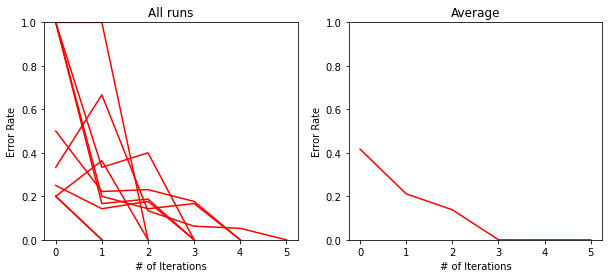

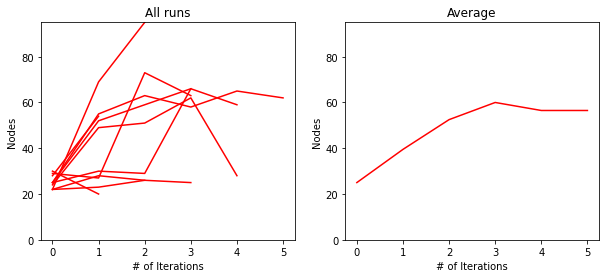

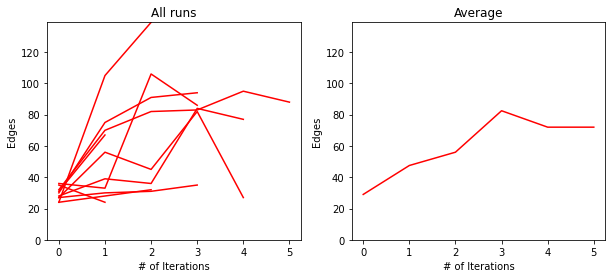

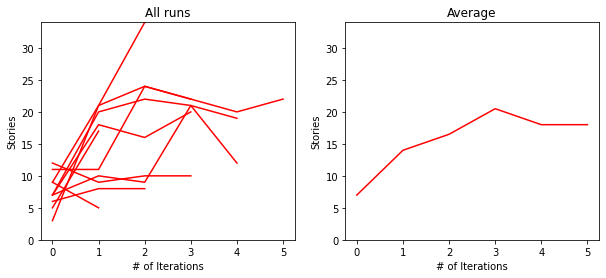

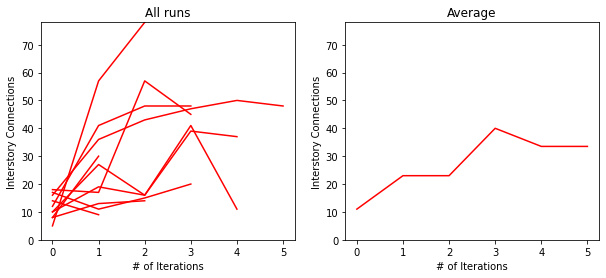

In [36]:
plot_all(all_iterations, all_percents, all_complexities)

### Biden

In [37]:
all_iterations = []
all_percents = []
all_counts = []
all_complexities = []
total_samples = base_total_samples
subset_query = query.loc[10:].astype({'id': 'int32'})
i = 0

while i < total_samples:
    print("===================================")
    print("Sample #" + str(i) + " (Valid Sample #" + str(len(all_complexities)) + ")")
    print("===================================")
    inner_iter_count = 0
    previous_actions = []
    percent_filter = 1.0
    percent_list = []
    drop = False
    complexity = pd.DataFrame(columns=['Nodes', 'Edges', 'Stories', 'Regular Stories', 'Singleton Stories', 'Interstory Connections'])
    random_state = i # Random state has to be consisten throughout the same iteration.
    
    while percent_filter > 0:
        G, graph_df, storylines = generate_map(query, dataset, k_input=8, start_nodes=[10], 
                                               previous_actions=previous_actions, verbose=False, 
                                               random_state=random_state, force_cluster=True)
        
        all_relevant_nodes = subset_query[subset_query.title.str.contains('biden', case=False) 
                                                 | subset_query.title.str.contains('biden', case=False)]
        relevant_nodes = graph_df[graph_df.title.str.contains('biden', case=False) | 
                                   graph_df.title.str.contains('biden', case=False)]
        
        unselected_relevant_nodes = (all_relevant_nodes.merge(relevant_nodes, on=['id'], how='left', indicator=True)
                                     .query('_merge == "left_only"')
                                     .drop('_merge', 1))
        relevant_node_list = [str(node) for node in relevant_nodes.id.tolist()]
        # Select first 10% nodes.
        percentage = 10
        selected_nodes_df = unselected_relevant_nodes.head(int(len(unselected_relevant_nodes.index) * (percentage / 100)))
        selected_nodes_list = [str(node) for node in selected_nodes_df.id.tolist()]
        
        add_node = {"action": "add-node", "content": selected_nodes_list}
        previous_actions.append(add_node)
        
        # Mark nodes as part of the same cluster
        new_cluster = {"action": "add-cluster-list", "content": [relevant_node_list, 1]}
        previous_actions.append(new_cluster)
        
        # Are the relevant nodes connected?
        non_isolated_nodes = set()
        relevant_node_n = len(relevant_nodes)

        count_same_story = 0
        count_direct_connection = 0
        count_same_parent = 0
        count_same_children = 0
        count_has_path = 0
        for combination in itertools.combinations(relevant_node_list,2):
            pred_i = G.predecessors(combination[0])
            pred_j = G.predecessors(combination[1])
            succ_i = G.successors(combination[0])
            succ_j = G.successors(combination[1])
            if any(all(node in story for node in combination) for story in storylines) : # pair is in the same storyline
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_story += 1
            elif G.has_edge(*combination) or G.has_edge(*reversed(combination)): # pair is directly connected (even if not in the same storyline)
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_direct_connection += 1
            elif set(pred_i) & set(pred_j): # pair shares the same parent/predecessors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_parent += 1
            elif set(succ_i) & set(succ_j): # pair shares the same children/succesors.
                non_isolated_nodes.add(combination[0])
                non_isolated_nodes.add(combination[1])
                count_same_children += 1
        
        print("# of Relevant Nodes: " + str(relevant_node_n))
        print("Same story " + str(count_same_story), 
              "Direct connection " + str(count_direct_connection), 
              "Same parent " + str(count_same_parent),
              "Same children " + str(count_same_children))
            
        if relevant_node_n == 0:
            percent_filter = 0.0
        else:
            percent_filter = 1 - len(non_isolated_nodes) / relevant_node_n
        
        if percent_filter == 0 and inner_iter_count == 0: 
            # if the map was perfect from the start, we will need more samples and we should drop this one.
            drop = True
            total_samples += 1
            
        percent_list.append(percent_filter)
        
        inner_iter_count += 1
        print("Step: " + str(inner_iter_count), percent_filter, add_node, "Relevant nodes: " + str(relevant_node_list))
        
        # Complexity metrics
        n_nodes = G.number_of_nodes()# Number of nodes
        n_edges = G.number_of_edges()# Number of edges
        n_stories = len(storylines)# Number of storylines
        n_reg_stories = len([story for story in storylines if len(story) > 1])# Number of regular storylines
        n_singletons = len([story for story in storylines if len(story) == 1])# Number of singleton storylines
        total_interstory = 0
        for (story_i, story_j) in list(itertools.combinations(storylines, 2)):
            edge_boundary_list_i = list(nx.edge_boundary(G, story_i, story_j))
            edge_boundary_list_j = list(nx.edge_boundary(G, story_j, story_i))
            total_interstory += len(edge_boundary_list_i) + len(edge_boundary_list_j)
        # Number of inter-story connections 
        complexity_list = [n_nodes, n_edges, n_stories, n_reg_stories, n_singletons, total_interstory]
        print("Complexity: " + str(complexity_list))
        complexity.loc[len(complexity)] = complexity_list
        
        if len(previous_actions) >= 4:
            if previous_actions[-1] == previous_actions[-3]:
                break
    
    i += 1
    actions = []
    for action in previous_actions:
        actions += action['content']
    if not drop:
        all_iterations.append(inner_iter_count)
        all_percents.append(percent_list)
        all_counts.append(len(actions))
        all_complexities.append(complexity)

Sample #0 (Valid Sample #0)
# of Relevant Nodes: 6
Same story 2 Direct connection 3 Same parent 0 Same children 0
Step: 1 0.0 {'action': 'add-node', 'content': ['19', '21', '25', '32']} Relevant nodes: ['77', '129', '132', '133', '151', '152']
Complexity: [22, 27, 12, 3, 9, 17]
Sample #1 (Valid Sample #0)
# of Relevant Nodes: 11
Same story 8 Direct connection 4 Same parent 1 Same children 1
Step: 1 0.0 {'action': 'add-node', 'content': ['19', '21', '25']} Relevant nodes: ['53', '70', '71', '106', '107', '108', '111', '116', '127', '138', '143']
Complexity: [29, 36, 11, 7, 4, 18]
Sample #2 (Valid Sample #0)
# of Relevant Nodes: 4
Same story 1 Direct connection 0 Same parent 0 Same children 0
Step: 1 0.5 {'action': 'add-node', 'content': ['19', '21', '25', '32']} Relevant nodes: ['53', '127', '132', '146']
Complexity: [23, 27, 6, 4, 2, 10]
# of Relevant Nodes: 20
Same story 12 Direct connection 3 Same parent 1 Same children 17
Step: 2 0.09999999999999998 {'action': 'add-node', 'content':

# of Relevant Nodes: 6
Same story 2 Direct connection 0 Same parent 0 Same children 1
Step: 1 0.33333333333333337 {'action': 'add-node', 'content': ['19', '25', '32', '34']} Relevant nodes: ['21', '49', '127', '132', '138', '146']
Complexity: [28, 31, 5, 5, 0, 8]
# of Relevant Nodes: 15
Same story 2 Direct connection 5 Same parent 4 Same children 15
Step: 2 0.06666666666666665 {'action': 'add-node', 'content': ['42', '44', '51']} Relevant nodes: ['19', '21', '25', '32', '34', '39', '49', '53', '68', '74', '76', '127', '132', '138', '146']
Complexity: [49, 74, 19, 12, 7, 44]
# of Relevant Nodes: 28
Same story 35 Direct connection 8 Same parent 2 Same children 12
Step: 3 0.0357142857142857 {'action': 'add-node', 'content': ['70']} Relevant nodes: ['19', '21', '25', '32', '34', '39', '42', '44', '49', '51', '52', '53', '54', '68', '74', '76', '95', '104', '107', '111', '127', '129', '132', '133', '138', '142', '146', '154']
Complexity: [63, 79, 18, 13, 5, 34]
# of Relevant Nodes: 36
Same 

# of Relevant Nodes: 3
Same story 0 Direct connection 1 Same parent 0 Same children 0
Step: 1 0.33333333333333337 {'action': 'add-node', 'content': ['19', '21', '25', '32']} Relevant nodes: ['107', '111', '151']
Complexity: [22, 31, 8, 5, 3, 17]
# of Relevant Nodes: 12
Same story 4 Direct connection 2 Same parent 1 Same children 1
Step: 2 0.16666666666666663 {'action': 'add-node', 'content': ['32', '34', '39']} Relevant nodes: ['19', '21', '25', '44', '53', '70', '107', '108', '111', '118', '120', '151']
Complexity: [38, 31, 18, 9, 9, 11]
# of Relevant Nodes: 16
Same story 15 Direct connection 6 Same parent 0 Same children 11
Step: 3 0.0 {'action': 'add-node', 'content': ['19', '21', '25']} Relevant nodes: ['39', '44', '53', '70', '107', '108', '111', '117', '118', '120', '127', '142', '144', '147', '151', '154']
Complexity: [40, 35, 16, 10, 6, 11]


In [38]:
results_clustering = {"iterations": all_iterations, "percents": all_percents, "counts": all_counts, "complexity": [p.to_dict() for p in all_complexities]}
with open('results_add_biden_old.json', 'w') as fp:
    json.dump(results_clustering, fp)

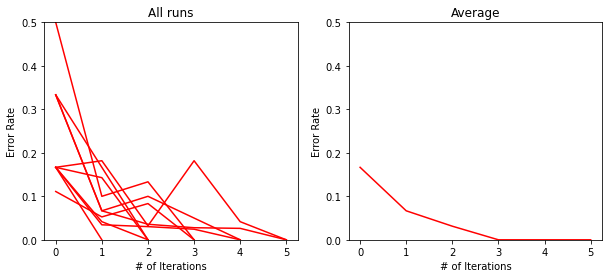

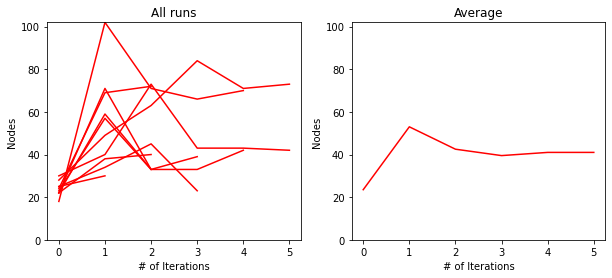

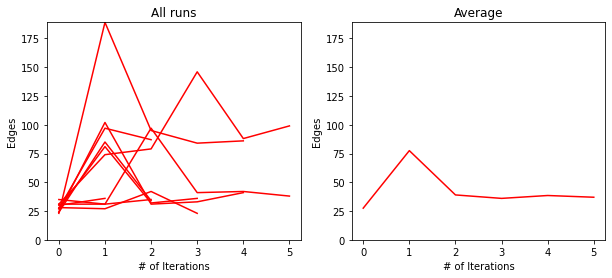

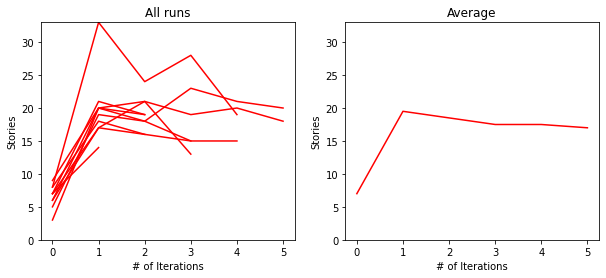

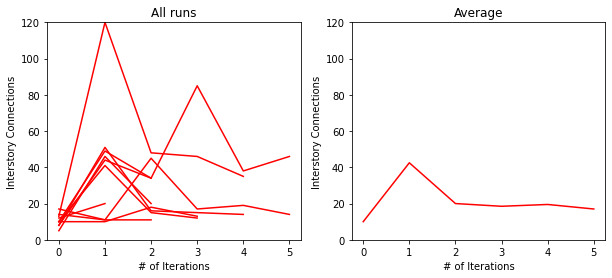

In [39]:
plot_all(all_iterations, all_percents, all_complexities)

## Generate Final Plot

In [40]:
f = open('results_delete_right_old.json')
results_delete_right = json.load(f)
f = open('results_delete_fox_bb_old.json')
results_delete_fox_bb = json.load(f)
f = open('results_delete_florida_old.json')
results_delete_florida = json.load(f)
f = open('results_delete_edges_old.json')
results_delete_edges = json.load(f)
f = open('results_consistent_story_old.json')
results_consistent_story = json.load(f)
f = open('results_clustering_bb_center_old.json')
results_clustering_bb_center = json.load(f)
f = open('results_clustering_florida_old.json')
results_clustering_florida = json.load(f)
f = open('results_add_florida_old.json')
results_add_florida = json.load(f)
f = open('results_add_biden_old.json')
results_add_biden = json.load(f)

In [41]:
def average_series(json_dict):
    all_iterations = json_dict['iterations']
    all_percents = json_dict['percents']
    max_iter = max(all_iterations)
    extended_percent_list = []
    for percent_list in all_percents:
        percent_list_extended = percent_list + [percent_list[-1] for _ in range(max_iter - len(percent_list))]
        extended_percent_list.append(percent_list_extended)
    extended_percent_array = np.array(extended_percent_list)
    average_percent = np.mean(extended_percent_array, axis=0)
    return average_percent

In [42]:
def generate_x_y(json_dict):
    y = average_series(json_dict)
    x = range(max(json_dict['iterations']))
    return x, y

In [43]:
average_percent = average_series(results_delete_right)
max_iter = max(results_delete_right['iterations'])

In [44]:
heigth = 40
width = 32
plt.rcParams['figure.figsize'] = [heigth/2.54, width/2.54]
plt.rcParams.update({'font.size': 14})

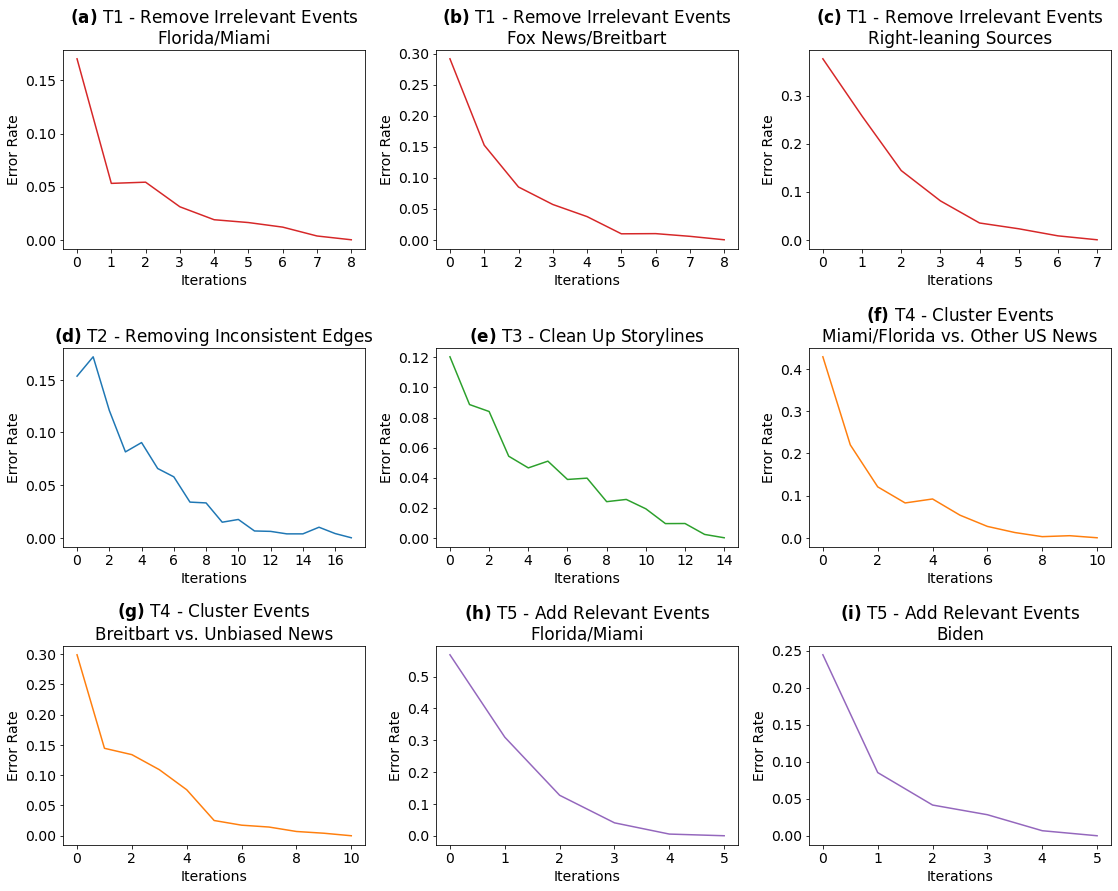

In [45]:
fig, axs = plt.subplots(3, 3)

x, y = generate_x_y(results_delete_florida)
axs[0, 0].plot(x, y, 'tab:red')
axs[0, 0].set_title(r'$\bf{(a)}$ ' + 'T1 - Remove Irrelevant Events\nFlorida/Miami')

x, y = generate_x_y(results_delete_fox_bb)
axs[0, 1].plot(x, y, 'tab:red')
axs[0, 1].set_title(r'$\bf{(b)}$ ' + 'T1 - Remove Irrelevant Events\nFox News/Breitbart')

x, y = generate_x_y(results_delete_right)
axs[0, 2].plot(x, y, 'tab:red')
axs[0, 2].set_title(r'$\bf{(c)}$ ' + 'T1 - Remove Irrelevant Events\nRight-leaning Sources')

x, y = generate_x_y(results_delete_edges)
axs[1, 0].plot(x, y, 'tab:blue')
axs[1, 0].set_title(r'$\bf{(d)}$ ' + 'T2 - Removing Inconsistent Edges')

x, y = generate_x_y(results_consistent_story)
axs[1, 1].plot(x, y, 'tab:green')
axs[1, 1].set_title(r'$\bf{(e)}$ ' + 'T3 - Clean Up Storylines')

x, y = generate_x_y(results_clustering_florida)
axs[1, 2].plot(x, y, 'tab:orange')
axs[1, 2].set_title(r'$\bf{(f)}$ ' + 'T4 - Cluster Events\nMiami/Florida vs. Other US News')

x, y = generate_x_y(results_clustering_bb_center)
axs[2, 0].plot(x, y, 'tab:orange')
axs[2, 0].set_title(r'$\bf{(g)}$ ' + 'T4 - Cluster Events\nBreitbart vs. Unbiased News')

x, y = generate_x_y(results_add_florida)
axs[2, 1].plot(x, y, 'tab:purple')
axs[2, 1].set_title(r'$\bf{(h)}$ ' + 'T5 - Add Relevant Events\nFlorida/Miami')

x, y = generate_x_y(results_add_biden)
axs[2, 2].plot(x, y, 'tab:purple')
axs[2, 2].set_title(r'$\bf{(i)}$ ' + 'T5 - Add Relevant Events\nBiden')

for ax in axs.flat:
    ax.set(xlabel='Iterations', ylabel='Error Rate')

fig.tight_layout()
# Hide x labels and tick labels for top plots and y ticks for right plots.
from matplotlib.ticker import MaxNLocator
for ax in axs.flat:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.label_outer()